# Analysis of NYC Taxi Cab Data

## Import Libraries and Connect to Database

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Connect to database:
con = sqlite3.connect("NYC-Taxi.db")

## Extract Observations

We will extract a sample of 1,000,000 observations consisting of green and yellow cab data to explore the characteristics of taxi rides in NYC's boroughs and surrounding areas.

In [2]:
# Store sample of green and yellow cab data into dataframes:
df1 = pd.read_sql(f"SELECT * FROM green_cabs ORDER BY random() LIMIT 500000", con)
df2 = pd.read_sql(f"SELECT * from yellow_cabs ORDER BY random() LIMIT 500000", con)

# Add labels for green and yellow cabs and rename pickup/dropoff datetime columns:
df1 = df1.rename(columns={"lpep_pickup_datetime": "pickup_datetime", "lpep_dropoff_datetime":"dropoff_datetime"})
df2 = df2.rename(columns={"tpep_pickup_datetime": "pickup_datetime", "tpep_dropoff_datetime":"dropoff_datetime"})
df1['cab'] = "green"
df2['cab'] = "yellow"

# Combine into one data frame:
frames = [df1, df2]
df = pd.concat(frames)

df.head()

,VendorID,pickup_datetime,dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,Source_file,cab
0,2.0,1.577190e+09,1.577191e+09,N,1.0,129,93,1.0,2.89,15.0,...,0.00,0.0,NaN,0.3,15.80,2.0,1.0,0.0,green_tripdata_2019-12.csv,green
1,2.0,1.558205e+09,1.558206e+09,N,1.0,25,106,1.0,0.85,5.0,...,0.00,0.0,NaN,0.3,5.80,2.0,1.0,0.0,green_tripdata_2019-05.csv,green
2,2.0,1.569264e+09,1.569264e+09,N,1.0,7,223,4.0,1.38,8.0,...,2.50,0.0,NaN,0.3,12.30,1.0,1.0,0.0,green_tripdata_2019-09.csv,green
3,2.0,1.572710e+09,1.572711e+09,N,1.0,52,40,1.0,0.92,5.0,...,1.16,0.0,NaN,0.3,6.96,1.0,1.0,0.0,green_tripdata_2019-11.csv,green
4,2.0,1.552744e+09,1.552745e+09,N,1.0,89,71,1.0,1.64,14.0,...,0.00,0.0,NaN,0.3,14.80,1.0,1.0,0.0,green_tripdata_2019-03.csv,green


## Data Cleaning

### Removing Outliers

In [3]:
# Check percentiles for each column:
df.quantile(q=np.array(range(0,11))*0.1)

,VendorID,pickup_datetime,dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0.0,1.0,1.230765e+09,1.230769e+09,1.0,1.0,1.0,0.0,-20329.08,-260.00,-4.50,-0.50,-90.50,-20.0,0.0,-0.3,-249.30,1.0,1.0,-2.75
0.1,1.0,1.549035e+09,1.549036e+09,1.0,41.0,42.0,1.0,0.61,5.00,0.00,0.50,0.00,0.0,0.0,0.3,7.30,1.0,1.0,0.00
0.2,1.0,1.551777e+09,1.551778e+09,1.0,66.0,69.0,1.0,0.90,6.00,0.00,0.50,0.00,0.0,0.0,0.3,9.19,1.0,1.0,0.00
0.3,2.0,1.554550e+09,1.554551e+09,1.0,79.0,90.0,1.0,1.13,7.00,0.00,0.50,0.00,0.0,0.0,0.3,10.56,1.0,1.0,0.00
0.4,2.0,1.557578e+09,1.557579e+09,1.0,100.0,129.0,1.0,1.41,8.50,0.00,0.50,0.00,0.0,0.0,0.3,12.09,1.0,1.0,0.00
0.5,2.0,1.560764e+09,1.560765e+09,1.0,137.0,145.0,1.0,1.78,10.00,0.50,0.50,1.00,0.0,0.0,0.3,13.80,1.0,1.0,2.50
0.6,2.0,1.564164e+09,1.564165e+09,1.0,161.0,164.0,1.0,2.24,11.50,0.50,0.50,1.62,0.0,0.0,0.3,15.95,1.0,1.0,2.50
0.7,2.0,1.567809e+09,1.567810e+09,1.0,170.0,196.0,1.0,2.97,14.50,1.00,0.50,2.06,0.0,0.0,0.3,18.80,2.0,1.0,2.50
0.8,2.0,1.571151e+09,1.571152e+09,1.0,230.0,233.0,2.0,4.26,19.00,1.00,0.50,2.76,0.0,0.0,0.3,23.76,2.0,1.0,2.50
0.9,2.0,1.574369e+09,1.574370e+09,1.0,239.0,239.0,2.0,7.44,28.00,2.75,0.50,3.99,0.0,0.0,0.3,34.05,2.0,1.0,2.50


Based on the above quantiles, the following filters should be applied:
- trip_distance > 0
- fare_amount > 0
- extra >= 0
- mta_tax >= 0
- tip_amount >= 0
- tolls_amount >= 0
- improvement_surcharge >= 0
- total_amount > 0
- congestion_surcharge >= 0

The upper limits should also be capped at the 99.9th percentile for:
- trip_distance
- fare_amount
- trip_time

Additionally, we only want to look at credit transactions because cash transactions are less likely to have a tip registered:
- payment_type == 1

In [4]:
# Change format to datetime where necessary:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'],unit='s')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'],unit='s')

# Trim data based on set limits and thresholds:
indices = (df['trip_distance'] > 0) &\
    (df['fare_amount'] > 0) &\
    (df['extra'] >= 0) &\
    (df['mta_tax'] >= 0) &\
    (df['tip_amount'] >= 0) &\
    (df['tolls_amount'] >= 0) &\
    (df['improvement_surcharge'] >= 0) &\
    (df['total_amount'] > 0) &\
    (df['total_amount'] <= df['total_amount'].quantile(.999)) &\
    (df['congestion_surcharge'] >= 0) &\
    (df['trip_distance'] <= df['trip_distance'].quantile(.999)) &\
    (df['fare_amount'] <= df['fare_amount'].quantile(.999))

df_cleaned = df[indices]
del indices
df_cleaned.shape

(872920, 22)

In [5]:
# Check for NA's:
df_cleaned.isna().sum()

VendorID                   1430
pickup_datetime               0
dropoff_datetime              0
store_and_fwd_flag         1430
RatecodeID                 1430
PULocationID                  0
DOLocationID                  0
passenger_count            1430
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
ehail_fee                872893
improvement_surcharge         0
total_amount                  0
payment_type               1430
trip_type                465114
congestion_surcharge          0
Source_file                   0
cab                           0
dtype: int64

In [6]:
# Set cleaned dataset without outliers and inspect:
df = df_cleaned
del df_cleaned
df.head()

,VendorID,pickup_datetime,dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,Source_file,cab
0,2.0,2019-12-24 12:13:12,2019-12-24 12:37:14,N,1.0,129,93,1.0,2.89,15.0,...,0.00,0.0,NaN,0.3,15.80,2.0,1.0,0.0,green_tripdata_2019-12.csv,green
1,2.0,2019-05-18 18:49:57,2019-05-18 18:53:22,N,1.0,25,106,1.0,0.85,5.0,...,0.00,0.0,NaN,0.3,5.80,2.0,1.0,0.0,green_tripdata_2019-05.csv,green
2,2.0,2019-09-23 18:35:49,2019-09-23 18:45:32,N,1.0,7,223,4.0,1.38,8.0,...,2.50,0.0,NaN,0.3,12.30,1.0,1.0,0.0,green_tripdata_2019-09.csv,green
3,2.0,2019-11-02 15:57:48,2019-11-02 16:01:43,N,1.0,52,40,1.0,0.92,5.0,...,1.16,0.0,NaN,0.3,6.96,1.0,1.0,0.0,green_tripdata_2019-11.csv,green
4,2.0,2019-03-16 13:40:17,2019-03-16 14:02:25,N,1.0,89,71,1.0,1.64,14.0,...,0.00,0.0,NaN,0.3,14.80,1.0,1.0,0.0,green_tripdata_2019-03.csv,green


## Feature Engineering

To better understand the data, we will add the following features to the main dataset:

* Borough = the borough the passenger is picked up in.
* Zone = the zone the passenger is picked up in (e.g. East Elmhurst).
* trip_time = total trip time.
* trip_speed = average speed of the trip (in miles per hour).
* tip_indicator = indicates whether a passenger tips (1 or 0).
* holiday_* = indicates whether the ride was on a holiday.
* hour_* = hour of day of the trip.
* day = day of the pickup.

In [7]:
# Include pickup borough:

#Store Pickup location borough names and merge to main data frame:
df_location = pd.read_csv("/Users/mbp/Documents/Side Projects/NYC Taxi Cab Scratch/taxi+_zone_lookup.csv")
df_location['DOLocationID'] = df_location['LocationID']
df_location = df_location.rename(columns = {'LocationID':'PULocationID'})

# Add borough and Zone name:
df = df.merge(df_location[['PULocationID', 'Borough', 'Zone']], on = "PULocationID", how = 'left')

# Include trip time:
df['trip_time'] = (df['dropoff_datetime'] - df['pickup_datetime']).astype('timedelta64[m]')

# Include trip speed:
df['trip_speed'] = ((df['trip_distance'])/(df['trip_time']))*60

# Create day of pickup:
df['day'] = df['pickup_datetime'].dt.day_name()

# Create tip indicator (1 = passenger tips, 0 = doesn't):
df['tip_indicator'] = [0 if x =='0' else 1 for x in df['tip_amount']] 

cal = calendar()
df['date'] = pd.to_datetime(df['dropoff_datetime']).dt.date
holidays = cal.holidays(start=df['date'].min(), end=df['date'].max(), return_name=True)
holidays = holidays.reset_index(name='holiday').rename(columns={'index':'date'})
holidays['date'] = pd.to_datetime(holidays['date']).dt.date
df = pd.merge(df, holidays, on = 'date', how='left')

# create dummys for holiday:
df = pd.get_dummies(df,dummy_na= True, columns= ['holiday'])

# Add NYE holiday:
df['holiday_NYE'] = np.where((pd.to_datetime(df['date']).dt.month == 12) & \
                     (pd.to_datetime(df['date']).dt.day == 31), 1, 0)

# Add hour of day variable:
hour = pd.get_dummies(df['pickup_datetime'].dt.hour, dummy_na= True)
hour.columns = ['hour_' + str(col) for col in hour.columns]
df = pd.concat([df, hour], axis=1)

# Clean up column names:
df.columns = df.columns.str.replace(" ","_")
df.columns = df.columns.str.replace(".0$","")

## Note: Remove column of reference class?

Inspect the added features to check for any outliers.

In [8]:
df.head()

,VendorID,pickup_datetime,dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_nan
0,2.0,2019-12-24 12:13:12,2019-12-24 12:37:14,N,1.0,129,93,1.0,2.89,15.0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,2019-05-18 18:49:57,2019-05-18 18:53:22,N,1.0,25,106,1.0,0.85,5.0,...,0,0,0,1,0,0,0,0,0,0
2,2.0,2019-09-23 18:35:49,2019-09-23 18:45:32,N,1.0,7,223,4.0,1.38,8.0,...,0,0,0,1,0,0,0,0,0,0
3,2.0,2019-11-02 15:57:48,2019-11-02 16:01:43,N,1.0,52,40,1.0,0.92,5.0,...,1,0,0,0,0,0,0,0,0,0
4,2.0,2019-03-16 13:40:17,2019-03-16 14:02:25,N,1.0,89,71,1.0,1.64,14.0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df[['trip_speed','trip_time','trip_distance']].describe()

,trip_speed,trip_time,trip_distance
count,8.729200e+05,872920.000000,872920.000000
mean,inf,18.902692,3.018262
std,NaN,81.555516,3.595451
min,-1.500000e+01,-54.000000,0.010000
25%,8.250000e+00,6.000000,1.020000
50%,1.092857e+01,11.000000,1.750000
75%,1.470000e+01,18.000000,3.300000
max,inf,8034.000000,28.350000


There are negative times and speeds - we will remove these and include only positive values.

In [10]:
indices = (df['trip_time'] > 0) &\
    (df['trip_speed'] > 0) &\
    (df['trip_time'] <= df['trip_time'].quantile(.99)) &\
    (df['trip_speed'] <= df['trip_speed'].quantile(.99))
    
df_cleaned = df[indices]
del indices
df_cleaned.shape

(855563, 66)

## Final Dataset for Analysis & Modeling

In [11]:
# Final Dataset:
df = df_cleaned
del df_cleaned

In [12]:
df.columns

Index(['VendorID', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag',
       'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count',
       'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'ehail_fee', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'congestion_surcharge', 'Source_file',
       'cab', 'Borough', 'Zone', 'trip_time', 'trip_speed', 'day',
       'tip_indicator', 'date', 'holiday_Christmas', 'holiday_Columbus_Day',
       'holiday_July_4th', 'holiday_Labor_Day',
       'holiday_Martin_Luther_King_Jr._Day', 'holiday_Memorial_Day',
       'holiday_New_Years_Day', 'holiday_Presidents_Day',
       'holiday_Thanksgiving', 'holiday_Veterans_Day', 'holiday_nan',
       'holiday_NYE', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'ho

In [13]:
# Write final dataset to database:
cur = con.cursor()
cur.execute('SELECT name from sqlite_master where type= "table"')
cur.fetchall()

[('green_cabs',), ('yellow_cabs',)]

## Exploratory Data Analysis

We will examine summary statistics of all variables to get a better look at the structure of the data.

In [14]:
# Summary stats and structure of data:
df.describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_nan
count,854214.000000,854214.000000,855563.000000,855563.000000,854214.000000,855563.000000,855563.000000,855563.000000,855563.000000,855563.000000,...,855563.000000,855563.000000,855563.000000,855563.000000,855563.000000,855563.000000,855563.000000,855563.000000,855563.000000,855563.0
mean,1.739186,1.078901,136.807506,146.245733,1.444674,2.902116,12.685986,0.794005,0.496149,1.650155,...,0.057961,0.058325,0.064235,0.069394,0.064277,0.055728,0.052974,0.048247,0.039034,0.0
std,0.448253,0.615249,73.954479,74.696299,1.110284,3.329294,9.777668,1.064772,0.043720,2.252228,...,0.233669,0.234358,0.245171,0.254123,0.245246,0.229396,0.223983,0.214287,0.193676,0.0
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,1.000000,74.000000,79.000000,1.000000,1.020000,6.500000,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,2.000000,1.000000,138.000000,148.000000,1.000000,1.740000,9.500000,0.500000,0.500000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,2.000000,1.000000,196.000000,229.000000,1.000000,3.250000,15.000000,1.000000,0.500000,2.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,4.000000,99.000000,265.000000,265.000000,8.000000,28.350000,92.000000,18.000000,0.870000,88.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


## Data Analysis and Visualization

Now that we've cleaned and inspected the dataset, we can analyze it and use visualizations to get a better understanding of the characteristics of trips between yellow and green cabs, and understand tip amounts amongst all trips.

### Summary of Holiday Trips, Trips by Hours of Day, Trips by Day

In [15]:
df.day.value_counts()

Friday       132941
Thursday     129315
Saturday     125823
Wednesday    125562
Tuesday      123231
Monday       113183
Sunday       105508
Name: day, dtype: int64

In [16]:
holiday_sm = pd.DataFrame(data = df.iloc[:,29:41].apply(lambda x: x.value_counts()).T.rename_axis('holiday').reset_index())
holiday_sm

,holiday,0,1
0,holiday_Christmas,854458,1105
1,holiday_Columbus_Day,853710,1853
2,holiday_July_4th,854081,1482
3,holiday_Labor_Day,854084,1479
4,holiday_Martin_Luther_King_Jr._Day,854518,1045
5,holiday_Memorial_Day,853846,1717
6,holiday_New_Years_Day,855544,19
7,holiday_Presidents_Day,853222,2341
8,holiday_Thanksgiving,854050,1513
9,holiday_Veterans_Day,853718,1845


Text(0.5, 1.0, 'Number of Trips by Holiday')

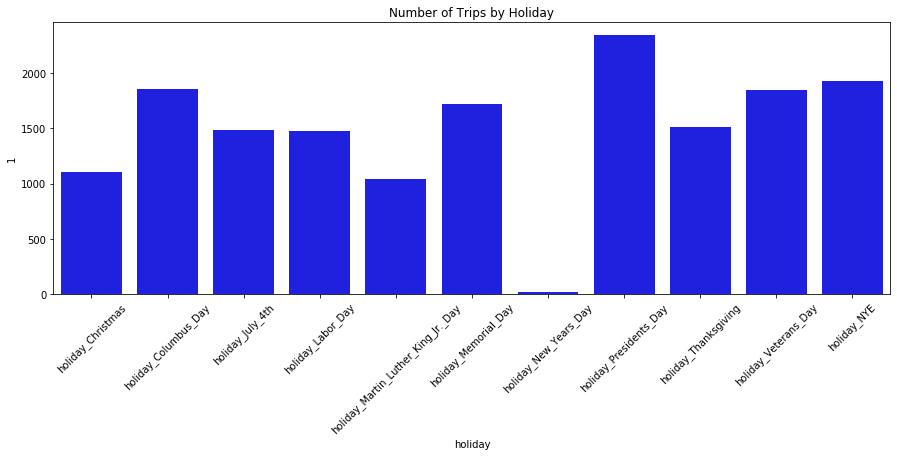

In [17]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
sns.barplot(x = holiday_sm.drop(10)['holiday'], y = holiday_sm.drop(10)[1], color = "blue").set_title("Number of Trips by Holiday")

In [18]:
hours_sm = pd.DataFrame(data = df.iloc[:,41:65].apply(lambda x: x.value_counts()).T.rename_axis('hour').reset_index())
hours_sm['percent'] = hours_sm[1]/(hours_sm[1] + hours_sm[0])
hours_sm

,hour,0,1,percent
0,hour_0,831418,24145,0.028221
1,hour_1,838956,16607,0.019411
2,hour_2,843902,11661,0.013630
3,hour_3,847229,8334,0.009741
4,hour_4,848832,6731,0.007867
5,hour_5,848808,6755,0.007895
6,hour_6,840597,14966,0.017493
7,hour_7,826951,28612,0.033442
8,hour_8,816021,39542,0.046218
9,hour_9,813691,41872,0.048941


Text(0.5, 1.0, 'Percent of Trips by hour of day')

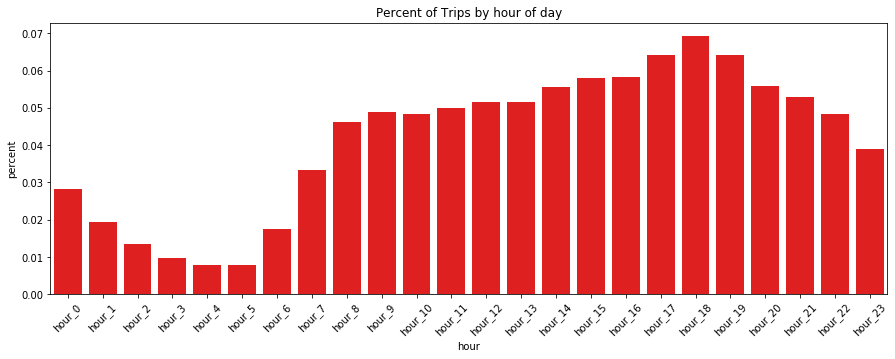

In [19]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
sns.barplot(x = hours_sm['hour'], y = hours_sm['percent'], color = "red").set_title("Percent of Trips by hour of day")

Text(0.5, 1.0, 'Percent of Trips by hour of day - Saturday')

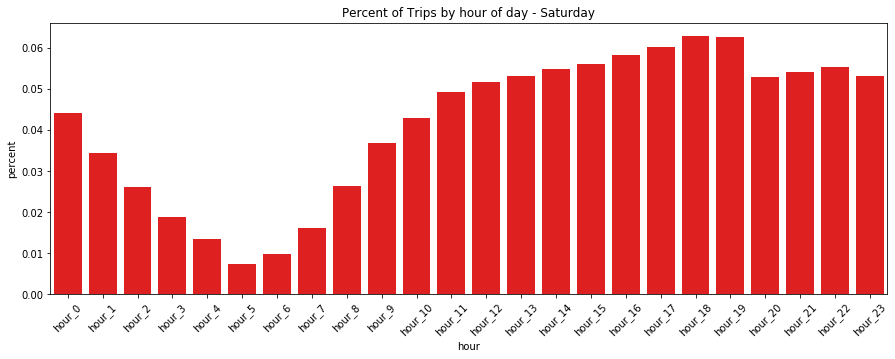

In [20]:
hours_sat = pd.DataFrame(data = df[df['day']== "Saturday"].iloc[:,41:65].apply(lambda x: x.value_counts()).T.rename_axis('hour').reset_index())
hours_sat['percent'] = hours_sat[1]/(hours_sat[1]+hours_sat[0])
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)

sns.barplot(x = hours_sat['hour'], y = hours_sat['percent'], color = "red").set_title("Percent of Trips by hour of day - Saturday")


### Total Fare Amount

Text(0.5, 1.0, 'Total Fare Amount')

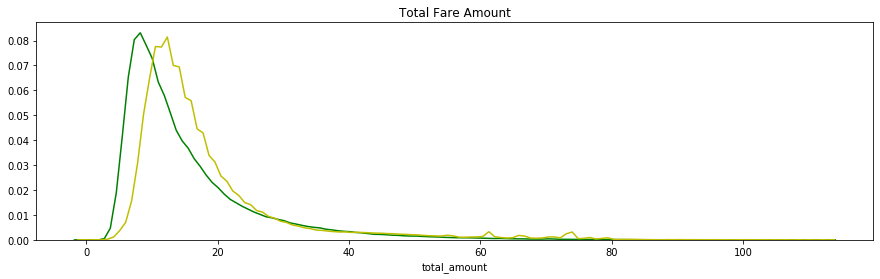

In [21]:
plt.figure(figsize=(15,4))
sns.distplot(df[df['cab'] == 'green']['total_amount'], hist=False, color = "green")
sns.distplot(df[df['cab'] == "yellow"]['total_amount'], hist=False, color = "y").set_title('Total Fare Amount')

In [22]:
df.groupby('cab')['total_amount'].mean()

cab
green     15.42728
yellow    18.57006
Name: total_amount, dtype: float64

On average, the total fare amount for yellow cabs is slightly greater than green cabs. We can check if this is due to longer trip times & higher distances traveled in yellow cabs than green cabs, shown below:

### Total Trip Time

Text(0.5, 1.0, 'Total Trip Time')

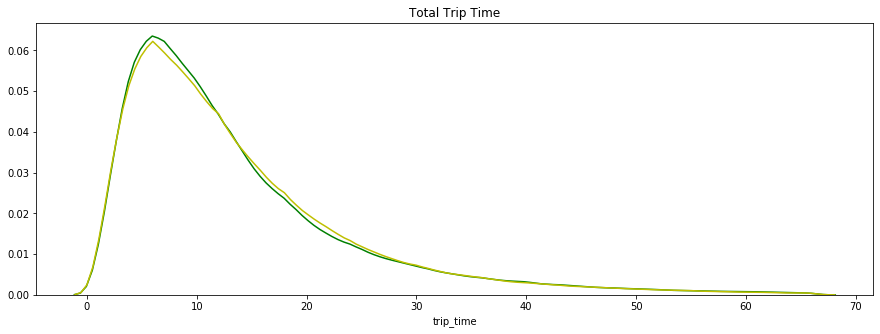

In [23]:
plt.figure(figsize=(15,5))
sns.distplot(df[df['cab']=="green"]['trip_time'], hist = False, color = "green")
sns.distplot(df[df['cab']=="yellow"]['trip_time'], hist = False, color = "y").set_title('Total Trip Time')

In [24]:
df.groupby('cab')['trip_time'].mean()

cab
green     13.704978
yellow    13.824090
Name: trip_time, dtype: float64

Text(0.5, 1.0, 'Total Trip Distance')

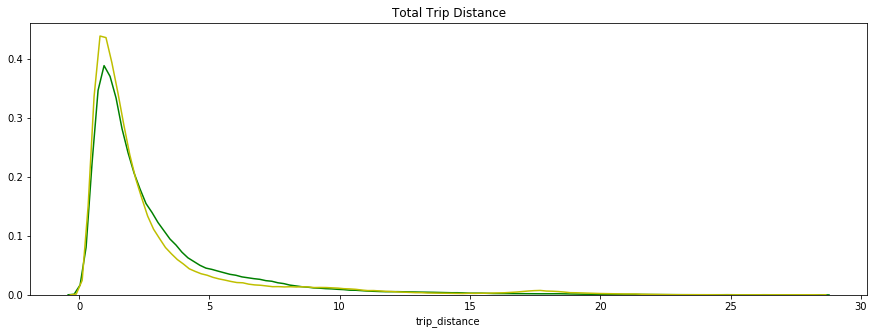

In [25]:
plt.figure(figsize=(15,5))
sns.distplot(df[df['cab']=="green"]['trip_distance'], hist = False, color = "green")
sns.distplot(df[df['cab']=="yellow"]['trip_distance'], hist = False, color = "y").set_title('Total Trip Distance')

In [26]:
df.groupby('cab')['trip_distance'].mean()

cab
green     2.939422
yellow    2.869562
Name: trip_distance, dtype: float64

On average, the trip times and distances are approximately the same between both cabs (13-14 minutes and 3 miles, respectively).

### Total Tip Amount

Text(0.5, 1.0, 'Total Tip Amount')

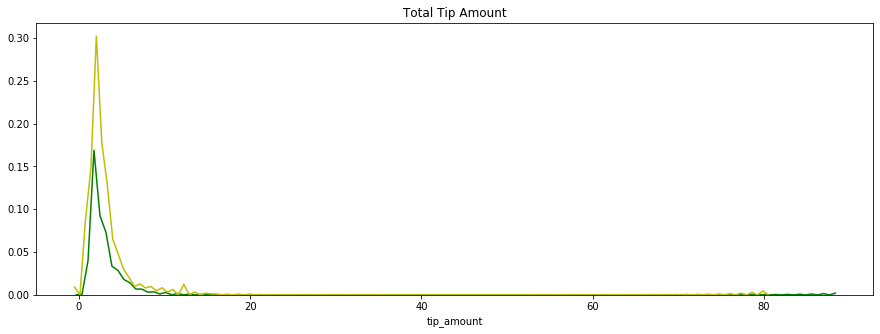

In [27]:
plt.figure(figsize=(15,5))
sns.distplot(df[df['cab']=="green"]['tip_amount'], hist = False, color = "green")
sns.distplot(df[df['cab']=="yellow"]['tip_amount'], hist = False, color = "y").set_title('Total Tip Amount')

In [28]:
df.groupby('cab')['tip_amount'].mean()

cab
green     1.082415
yellow    2.145575
Name: tip_amount, dtype: float64

In [29]:
df[df['tip_amount'] == 0].groupby('cab')['tip_amount'].count()

cab
green     240646
yellow    138391
Name: tip_amount, dtype: int64

In [30]:
df[df['tip_amount'] > 0].groupby('cab')['tip_amount'].count()

cab
green     158036
yellow    318490
Name: tip_amount, dtype: int64

In [31]:
df[df['tip_amount'] == 0].groupby(['cab', 'payment_type'])['payment_type'].count()

cab     payment_type
green   1.0              67909
        2.0             171521
        3.0                769
        4.0                431
        5.0                 16
yellow  1.0              11960
        2.0             122988
        3.0               1579
        4.0                519
Name: payment_type, dtype: int64

There are a large portion of transactions have 0 tips for both cabs. 
* For green, approximately 60% of all transactions don't have tips.
* For yellow, approximately 30% of all transactions dont have tips.

Most of the 0 tip transactions are cash **(shown below - 'payment_type = 2')**.
* 87% of no-tip transactions in yellow cabs are cash (9% are credit card)
* 61% of no-tip transactions in green cabs are cash (27% are credit card).

This could mean that taxi cab drivers do not record tip amounts for cash transcations (possibly for tax reasons).

### Total Transactions with No Tip (Removing all Cash Transactions)

In [32]:
df_nocash = df[df['payment_type'] != 2]
df_nocash[df_nocash['tip_amount'] == 0].groupby('cab')['tip_amount'].count()

cab
green     69125
yellow    15403
Name: tip_amount, dtype: int64

### Trip Speed vs. Tip Amount

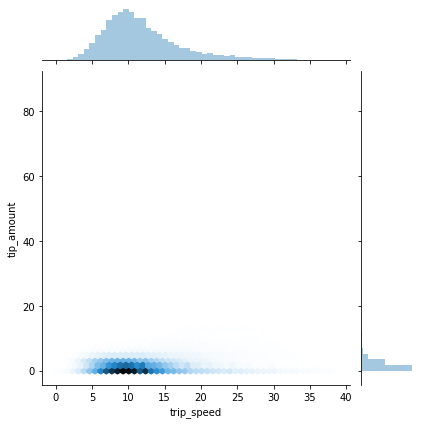

In [33]:
sns.jointplot('trip_speed', 'tip_amount', data = df, kind = 'hex')

In [34]:
# Pearson correlation coefficient of trip speed and tip amount:
df[['trip_speed','tip_amount']].corr()

,trip_speed,tip_amount
trip_speed,1.00000,0.19924
tip_amount,0.19924,1.00000


There is a weak correlation between trip speed and the tip amount.

### Summary of Tips by Payment Type & Borough

In [35]:
df.groupby(['cab', 'payment_type'])['tip_amount'].describe()

count      mean       std  min  25%   50%   75%    max
cab    payment_type                                                           
green  1.0           225940.0  1.909910  2.114020  0.0  0.0  1.59  2.76  88.00
       2.0           171526.0  0.000083  0.016659  0.0  0.0  0.00  0.00   4.88
       3.0              769.0  0.000000  0.000000  0.0  0.0  0.00  0.00   0.00
       4.0              431.0  0.000000  0.000000  0.0  0.0  0.00  0.00   0.00
       5.0               16.0  0.000000  0.000000  0.0  0.0  0.00  0.00   0.00
yellow 1.0           330433.0  2.966363  2.415084  0.0  1.7  2.36  3.45  80.00
       2.0           122997.0  0.000231  0.030484  0.0  0.0  0.00  0.00   7.08
       3.0             1582.0  0.004564  0.113024  0.0  0.0  0.00  0.00   3.76
       4.0              520.0  0.018692  0.426250  0.0  0.0  0.00  0.00   9.72

In [36]:
df.groupby('Borough')['tip_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
Borough,,,,,,,,
Bronx,22667.0,0.288918,1.332833,0.0,0.0000,0.000,0.0000,55.00
Brooklyn,113908.0,1.309074,2.044760,0.0,0.0000,0.000,2.0600,88.00
EWR,2.0,11.025000,7.106423,6.0,8.5125,11.025,13.5375,16.05
Manhattan,568229.0,1.765827,2.008186,0.0,0.0000,1.610,2.6600,80.00
Queens,146815.0,1.668870,3.131619,0.0,0.0000,0.000,2.0000,80.00
Staten Island,136.0,0.650221,1.895997,0.0,0.0000,0.000,0.0000,10.00
Unknown,3806.0,2.004446,2.700578,0.0,0.0000,1.660,2.7000,70.49


## Modeling

Models to consider:
* Zero Inflated
* Random Forest
* XGBoost
* Neural Net
* GAM
* KNN
* Logistic Regression (to predict action of tipping)

## Generalized Additive Model (GAM)

In [37]:
# Only include payment type = 1 (credit cards):
df = df[df['payment_type'] == 1]

In [38]:
# Features to include in model:
features = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',  'cab', 'Borough', 'Zone',
        'trip_time', 'trip_speed', 'day', 'holiday_Christmas',
       'holiday_Columbus_Day', 'holiday_Dr._Martin_Luther_King_Jr.',
       'holiday_July_4th', 'holiday_Labor_Day', 'holiday_MemorialDay',
       'holiday_New_Years_Day', 'holiday_Presidents_Day',
       'holiday_Thanksgiving', 'holiday_Veterans_Day', 'holiday_nan',
       'holiday_NYE', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']

In [39]:
#Set train and test sets:
train_df = df.sample(frac=0.8, random_state=44)
test_df = df.drop(train_df.index)

# Set features (X) and target (y) matrices in the training set:
X = train_df.iloc[:,np.r_[7:12,13,15,19,21:27,29:65]]

# Dummy coding categorical variables:
cols_to_dummy = ['cab', 'Borough', 'Zone', 'day']
X = pd.get_dummies(X, columns = cols_to_dummy)
del cols_to_dummy

y = train_df.loc[:,'tip_amount']

# Train-test split to fit the model on 80% of the training data, and test on the remaining 20% of the training data:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [60]:
# Fit GAM:
from pygam import LinearGAM, s, f, GAM
pd.set_option('display.max_columns', None)
X_train.head()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,trip_time,trip_speed,holiday_Christmas,holiday_Columbus_Day,holiday_July_4th,holiday_Labor_Day,holiday_Martin_Luther_King_Jr._Day,holiday_Memorial_Day,holiday_New_Years_Day,holiday_Presidents_Day,holiday_Thanksgiving,holiday_Veterans_Day,holiday_nan,holiday_NYE,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,cab_green,cab_yellow,Borough_Bronx,Borough_Brooklyn,Borough_EWR,Borough_Manhattan,Borough_Queens,Borough_Staten Island,Borough_Unknown,Zone_Allerton/Pelham Gardens,Zone_Alphabet City,Zone_Arden Heights,Zone_Arrochar/Fort Wadsworth,Zone_Astoria,Zone_Astoria Park,Zone_Auburndale,Zone_Baisley Park,Zone_Bath Beach,Zone_Battery Park,Zone_Battery Park City,Zone_Bay Ridge,Zone_Bay Terrace/Fort Totten,Zone_Bayside,Zone_Bedford,Zone_Bedford Park,Zone_Bellerose,Zone_Belmont,Zone_Bensonhurst East,Zone_Bensonhurst West,Zone_Bloomfield/Emerson Hill,Zone_Bloomingdale,Zone_Boerum Hill,Zone_Borough Park,Zone_Breezy Point/Fort Tilden/Riis Beach,Zone_Briarwood/Jamaica Hills,Zone_Brighton Beach,Zone_Broad Channel,Zone_Bronx Park,Zone_Bronxdale,Zone_Brooklyn Heights,Zone_Brooklyn Navy Yard,Zone_Brownsville,Zone_Bushwick North,Zone_Bushwick South,Zone_Cambria Heights,Zone_Canarsie,Zone_Carroll Gardens,Zone_Central Harlem,Zone_Central Harlem North,Zone_Central Park,Zone_Charleston/Tottenville,Zone_Chinatown,Zone_City Island,Zone_Claremont/Bathgate,Zone_Clinton East,Zone_Clinton Hill,Zone_Clinton West,Zone_Co-Op City,Zone_Cobble Hill,Zone_College Point,Zone_Columbia Street,Zone_Coney Island,Zone_Corona,Zone_Country Club,Zone_Crotona Park,Zone_Crotona Park East,Zone_Crown Heights North,Zone_Crown Heights South,Zone_Cypress Hills,Zone_DUMBO/Vinegar Hill,Zone_Douglaston,Zone_Downtown Brooklyn/MetroTech,Zone_Dyker Heights,Zone_East Chelsea,Zone_East Concourse/Concourse Village,Zone_East Elmhurst,Zone_East Flatbush/Farragut,Zone_East Flatbush/Remsen Village,Zone_East Flushing,Zone_East Harlem North,Zone_East Harlem South,Zone_East New York,Zone_East New York/Pennsylvania Avenue,Zone_East Tremont,Zone_East Village,Zone_East Williamsburg,Zone_Eastchester,Zone_Elmhurst,Zone_Elmhurst/Maspeth,Zone_Eltingville/Annadale/Prince's Bay,Zone_Erasmus,Zone_Far Rockaway,Zone_Financial District North,Zone_Financial District South,Zone_Flatbush/Ditmas Park,Zone_Flatiron,Zone_Flatlands,Zone_Flushing,Zone_Flushing Meadows-Corona Park,Zone_Fordham South,Zone_Forest Hills,Zone_Forest Park/Highland Park,Zone_Fort Greene,Zone_Fresh Meadows,Zone_Garment District,Zone_Glen Oaks,Zone_Glendale,Zone_Gowanus,Zone_Gramercy,Zone_Gravesend,Zone_Great Kills,Zone_Green-Wood Cemetery,Zone_Greenpoint,Zone_Greenwich Village North,Zone_Greenwich Village South,Zone_Grymes Hill/Clifton,Zone_Hamilton Heights,Zone_Hammels/Arverne,Zone_Heartland Village/Todt Hill,Zone_Highbridge,Zone_Highbridge Park,Zone_Hillcrest/Pomonok,Zone_Hollis,Zone_Homecrest,Zone_Howard Beach,Zone_Hudson Sq,Zone_Hunts Point,Zone_Inwood,Zone_Inwood Hill Park,Zone_JFK Airport,Zone_Jackson Heights,Zone_Jamaica,Zone_Jamaica Bay,Zone_Jamaica Estates,Zone_Kensington,Zone_Kew Gardens,Zone_Kew Gardens Hills,Zone_Kingsbridge Heights,Zone_Kips Bay,Zone_LaGuardia Airport,Zone_Laurelton,Zone_Lenox Hill East,Zone_Lenox Hill West,Zone_Lincoln Square East,Zone_Lincoln Square West,Zone_Little Italy/NoLiTa,Zone_Long Island City/Hunters Point,Zone_Long Island City/Queens Plaza,Zone_Longwood,Zone_Lower East Side,Zone_Madison,Zone_Manhattan Beach,Zone_Manhattan Valley,Zone_Manhattanville,Zone_Marble Hill,Zone_Marine Park/Floyd Bennett Field,Zone_Marine Park/Mill Basin,Zone_Mariners Harbor,Zone_Maspeth,Zone_Meatpacking/West Village West,Zone_Melrose South,Zone_Middle Village,Zone_Midtown Center,Zone_Midtown East,Zone_Midtown North,Zone_Midtown South,Zone_Midwood,Zone_Morningside Heights,Zone_Morr

In [63]:
gam = LinearGAM(n_splines=4).gridsearch(X_train.values, y_train.values)

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

KeyboardInterrupt: 

## K-Nearest Neighbors (KNN)

In [41]:
from sklearn import neighbors
knn_reg = neighbors.KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

### Predictions on test set

In [42]:
y_preds = knn_reg.predict(X_test)

In [47]:
from sklearn.metrics import mean_squared_error 
from math import sqrt

sqrt(mean_squared_error(y_test,y_preds))

1.663281156514651

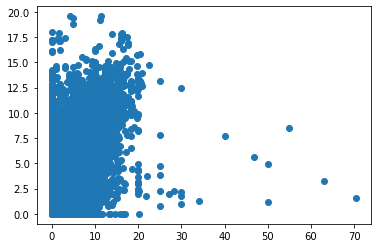

In [50]:
plt.scatter(y_test, y_preds)

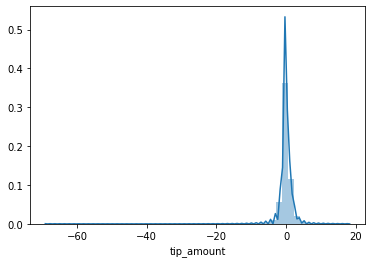

In [55]:
errors = y_preds - y_test
sns.distplot(errors, hist = True)

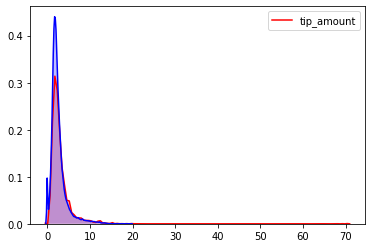

In [64]:
p1 = sns.kdeplot(y_test, shade=True, color="r")
p1 = sns.kdeplot(y_preds, shade=True, color="b")
plt.show()

### Try different values of K

In [49]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 2.1247850703417415
RMSE value for k=  2 is: 1.8341815600036138
RMSE value for k=  3 is: 1.7343160739005505
RMSE value for k=  4 is: 1.688205820275311
RMSE value for k=  5 is: 1.663281156514651
RMSE value for k=  6 is: 1.64644694537516
RMSE value for k=  7 is: 1.6323183277333528
RMSE value for k=  8 is: 1.6212151023483754
RMSE value for k=  9 is: 1.6147633933845966
RMSE value for k=  10 is: 1.6101663939965567
RMSE value for k=  11 is: 1.6051783754864763
RMSE value for k=  12 is: 1.5999386193378382
RMSE value for k=  13 is: 1.5961109180883206
RMSE value for k=  14 is: 1.5936685071980177
RMSE value for k=  15 is: 1.5922791108404775
RMSE value for k=  16 is: 1.5904580590704074
RMSE value for k=  17 is: 1.5895587372302546
RMSE value for k=  18 is: 1.5888824149577272
RMSE value for k=  19 is: 1.5870544276608096
RMSE value for k=  20 is: 1.5875344411665608


Optimal value of k is around 5 or 6.